In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [116]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.RandomCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [117]:
root = '../data/kaggle_train_128/'
torch.device("cuda")
train_data = datasets.ImageFolder(os.path.join(root, 'train_128'), transform=train_transform)
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
class_names = train_data.classes
print(class_names)
print(f'Training images available: {len(train_data)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

['0', '1', '2', '3', '4']
Training images available: 15000
cuda:0


Label: [0 2 3 2 1 3 4 2 4 0]
Class: 0 2 3 2 1 3 4 2 4 0


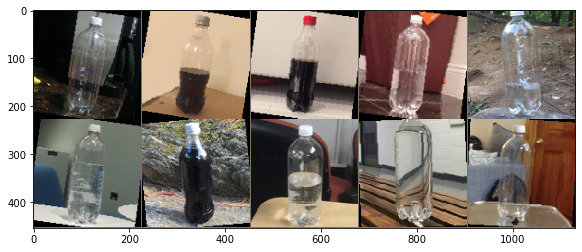

In [118]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [119]:
AlexNetmodel = models.alexnet(pretrained=True).cuda()
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [120]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [121]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 5),
                                 nn.LogSoftmax(dim=1)).cuda()
AlexNetmodel.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [122]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [123]:
count_parameters(AlexNetmodel)

 9437184
    1024
    5120
       5
________
 9443333


In [124]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [128]:
# AlexNetmodel = AlexNetmodel.to(device)
import time
start_time = time.time()

epochs = 2

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
#         if b == max_trn_batch:
#             break
        b+=1
        
        # Apply the model
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        y_pred = AlexNetmodel(X_train)
    
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
#         Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}\
            accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

#     # Run the testing batches
#     with torch.no_grad():
#         for b, (X_test, y_test) in enumerate(test_loader):
#             if b == max_tst_batch:
#                 break

#             # Apply the model
#             y_val = AlexNetmodel(X_test)

#             # Tally the number of correct predictions
#             predicted = torch.max(y_val.data, 1)[1] 
#             tst_corr += (predicted == y_test).sum()

#     loss = criterion(y_val, y_test)
#     test_losses.append(loss)
#     test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.29439729            accuracy:  71.850%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.67811441            accuracy:  73.800%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.69563615            accuracy:  74.683%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.37521291            accuracy:  74.487%
epoch:  0  batch: 1000 [ 10000/8000]  loss: 0.38587016            accuracy:  74.640%
epoch:  0  batch: 1200 [ 12000/8000]  loss: 0.66071391            accuracy:  74.767%
epoch:  0  batch: 1400 [ 14000/8000]  loss: 1.35162580            accuracy:  75.050%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.41963714            accuracy:  78.400%
epoch:  1  batch:  400 [  4000/8000]  loss: 1.48014474            accuracy:  78.400%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.30890304            accuracy:  78.050%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.60000807            accuracy:  78.412%
epoch:  1  batch: 1000 [ 10000/8000]  loss: 0.85572290           

In [129]:
test_data = datasets.ImageFolder('../data/kaggle_test_128/test_128/', transform=test_transform)
torch.manual_seed(42)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

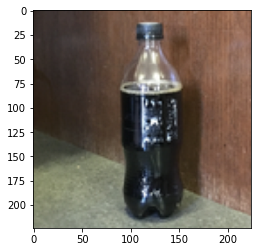

In [130]:
x = 5
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [131]:
filename = "../data/modified_prediction_labels_template.csv"
df = pd.read_csv(filename)
df.head()

,Id,label
0,00000.png,1
1,00001.png,1
2,00002.png,2
3,00003.png,2
4,00004.png,3


In [132]:
# AlexNet Model Prediction:
AlexNetmodel.eval()
with torch.no_grad():
    for x in range(3000):
        new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224).cuda()).argmax()
        df.loc[x,'label'] = int(new_pred)
        print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 4 4
Predicted value: 2 2
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 1 1
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted val

Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 2 2
Predicted value: 0 0
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 4 4
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 3 3
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted val

Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 1 1
Predicted value: 0 0
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 0 0
Predicted value: 1 1
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted val

Predicted value: 3 3
Predicted value: 3 3
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 3 3
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 0 0
Predicted value: 1 1
Predicted value: 0 0
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 0 0
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 3 3
Predicted value: 0 0
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 0 0
Predicted value: 3 3
Predicted value: 0 0
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 0 0
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 3 3
Predicted val

Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 2 2
Predicted value: 1 1
Predicted value: 0 0
Predicted value: 2 2
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted val

Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 1 1
Predicted val

Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 4 4
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 3 3
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted val

Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 1 1
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 2 2
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 3 3
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 1 1
Predicted value: 0 0
Predicted value: 0 0
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted value: 4 4
Predicted val

In [113]:
df.to_csv(filename,index=False)

In [106]:
df.loc[2,'label']=3

In [107]:
df.head()

,Id,label
0,00000.png,0
1,00001.png,0
2,00002.png,3
3,00003.png,0
4,00004.png,0


In [145]:
from PIL import Image
img = Image.open("../data/kaggle_train_128/train_128/1/03016.png").convert('LA')
t = transforms.ToTensor()
ans1 = t(img)
ans2 = t(Image.open("../data/kaggle_train_128/train_128/1/03016.png"))

In [168]:
np.stack((ans1,ans1),axis=0).shape

(2, 2, 128, 128)

In [148]:
ans1.shape, ans2.shape

(torch.Size([2, 128, 128]), torch.Size([3, 128, 128]))

In [178]:
ans1[0][0], ans1[1][0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0314,
         0.6118, 0.5373, 0.4157, 0.5725, 0.5020, 0.4824, 0.4941, 0.5490, 0.6627,
         0.7294, 0.7608, 0.7569, 0.7882, 0.7765, 0.6000, 0.5608, 0.5176, 0.5765,
         0.7137, 0.7451, 0.4824, 0.4667, 0.6235, 0.5451, 0.4235, 0.6392, 0.8471,
         0.8039, 0.8196, 0.8392, 0.8314, 0.8314, 0.8314, 0.8510, 0.7294, 0.7608,
         0.8353, 0.8235, 0.8235, 0.8275, 0.8275, 0.8235, 0.8275, 0.8314, 0.8353,
         0.8314, 0.8275, 0.8314, 0.8314, 0.8275, 0.8235, 0.8235, 0.8196, 0.8235,
         0.8275, 0.8275, 0.8235, 0.8235, 0.8118, 0.8039, 0.8078, 0.8157, 0.7843,
         0.7961, 0.8314, 0.7569, 0.6353, 0.5961, 0.7608, 0.8275, 0.8235, 0.8196,
         0.8353, 0.8314, 0.8314, 0.8314, 0.8275, 0.8196, 0.8275, 0.7765, 0.6980,
         0.7529, 0.8157, 0.8235, 0.8235, 0.8196, 0.8353, 0.7569, 0.6471, 0.6745,
         0.3647, 0.1686, 0.3137, 0.6549, 0.4392, 0.4196, 0.4235, 0.4314, 0.4392,
         0.4627, 0.3255, 0.3

In [159]:
img = np.array([[1, 2], [3, 4]])
print(img.shape)
stacked_img = np.stack((img,)*3, axis=-1)
print(stacked_img)
print(stacked_img.shape)

(2, 2)
[[[1 1 1]
  [2 2 2]]

 [[3 3 3]
  [4 4 4]]]
(2, 2, 3)


AttributeError: 'Image' object has no attribute 'channels'